## Noise generated images ##


**Goal:** Procedurally compute interesting background images


**Approach:** Use uniform random noise to select and perturb colors

## How's it made? ##

* Approach: direct pixel manipulation


* Select colors randomly from pre-defined colormaps


* Stripes sets rows of the canvas buffer to the same value


* The sub operation perturbs each pixel by replacing it from a random vertical neighbor within range [-distance, distance]


* Smoothing replaces each pixel with an average of its neighbors

## Background ##

* An image is represented as a block of pixels


* Each pixel is a tuple, usually either (r,g,b) or (r,g,b,a)


* RGBA components might range from 0 to 255, or from 0 to 1
    * Below, they range from 0 to 1


* In memory, the image is usually stored as a dense buffer
    * Ex. flat array
    * Ex. 3D matrix  <--- below, we use matrix format


* The pixel in the i'th row and j'th col can be set to the color (r,g,b) like so

```
//Setting colors in a flat array 
buffer[i * numCols + j + 0] = r
buffer[i * numCols + j + 1] = g
buffer[i * numCols + j + 2] = b
```
```
//Setting colors in a matrix
buffer[i][j][0] = r
buffer[i][j][1] = g
buffer[i][j][2] = b
```

## Test: Randomly choosing color components ##

For each pixel, we choose the values for each r,g,b randomly.

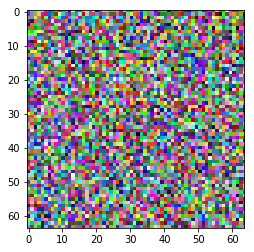

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random

width = 64
height = 64
depth = 3
numPixels = width * height
img = np.random.random((width, height, depth))
plt.imshow(img)

## Test: Randomly choosing color intensity ##

* Gray colors correspond to tuples where r = b = g. 


* Below we randomly choose an intensity, or gray value.

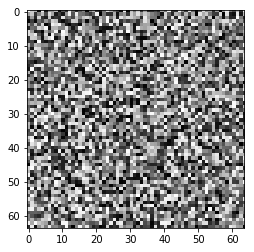

In [29]:
for i in range(width):
    for j in range(height):
        intensity = np.random.random_sample(1)
        img[i][j][0] = img[i][j][1] = img[i][j][2] = intensity
        
plt.imshow(img)

## Test: Making random color choices less random##

* We select colors randomly from a pre-defined colormap. 


* A colormap is a list of colors, or (r,g,b) triplets


* Colors correspond to indices into the colormap


* Below we randomly choose a colormap index

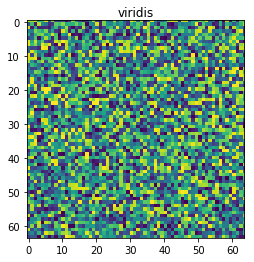

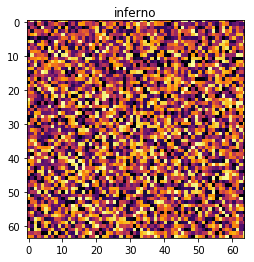

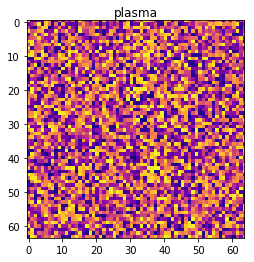

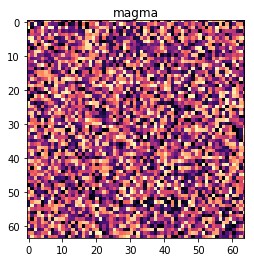

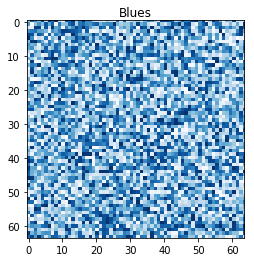

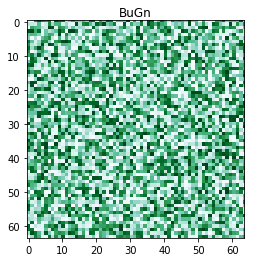

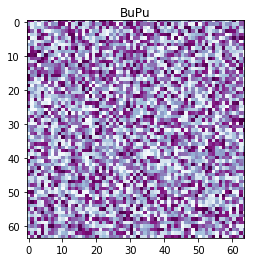

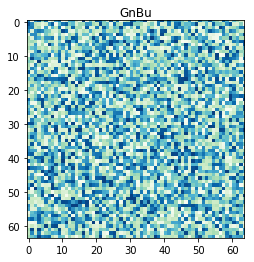

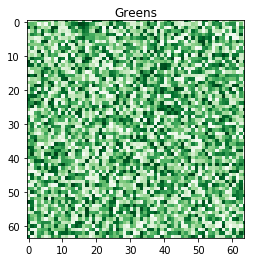

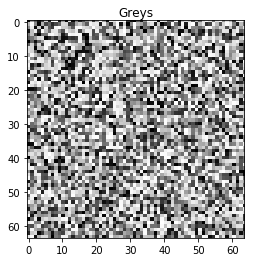

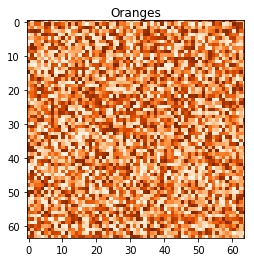

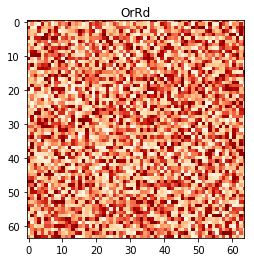

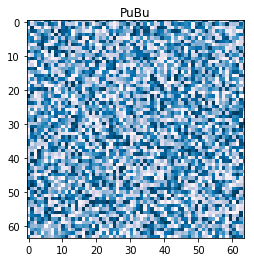

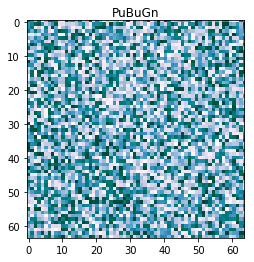

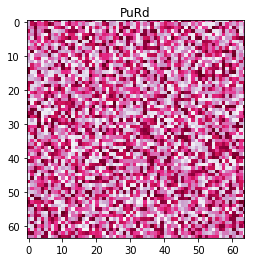

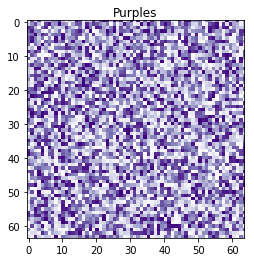

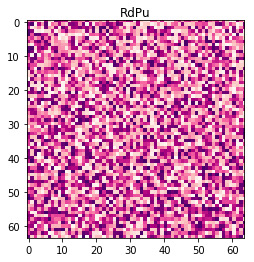

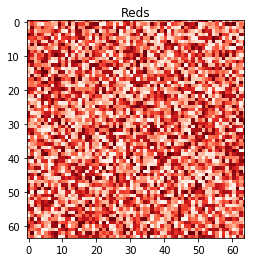

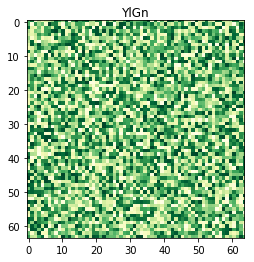

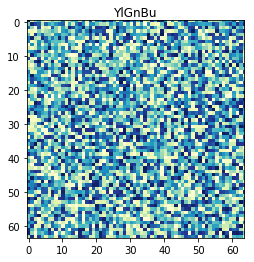

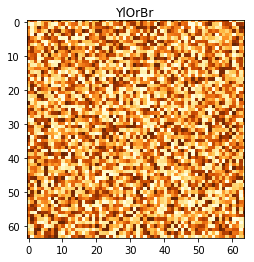

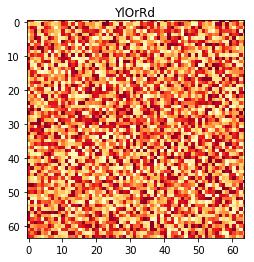

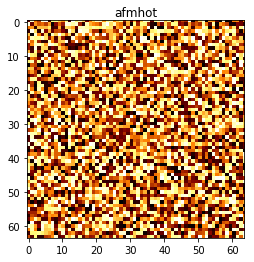

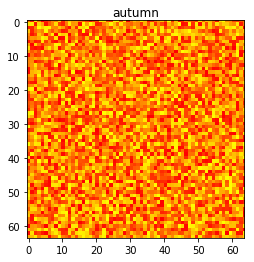

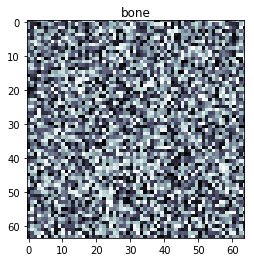

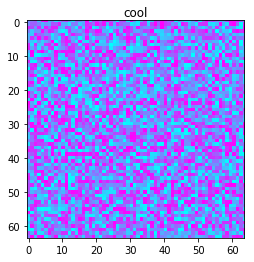

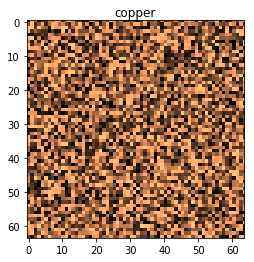

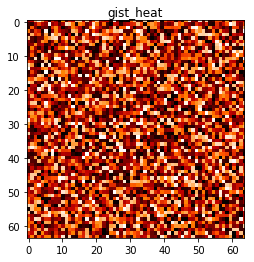

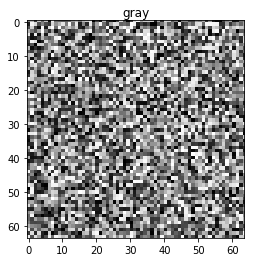

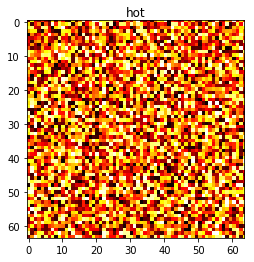

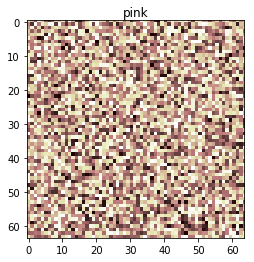

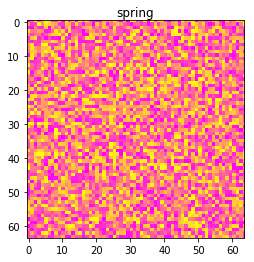

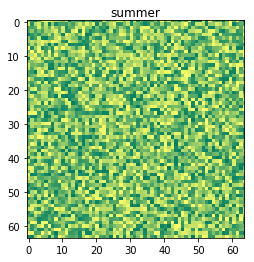

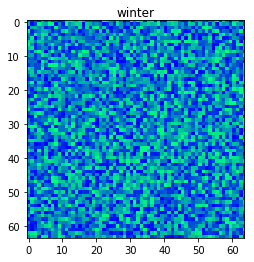

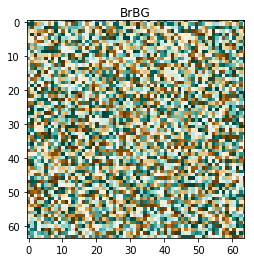

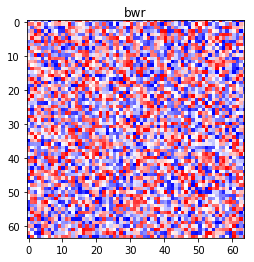

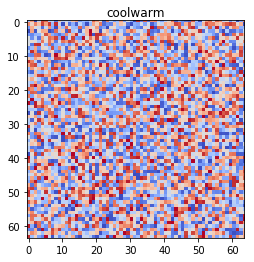

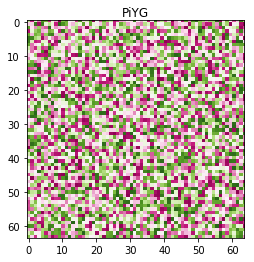

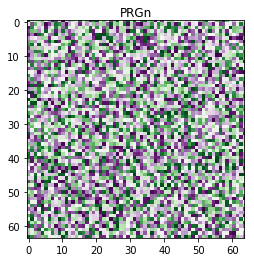

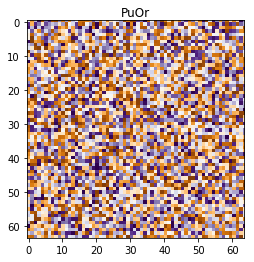

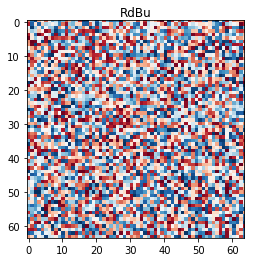

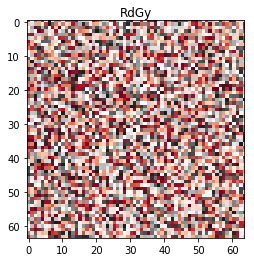

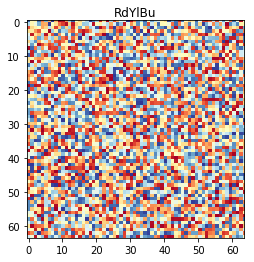

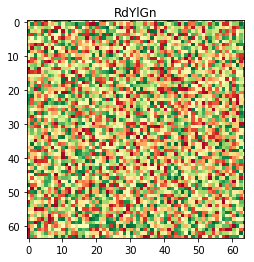

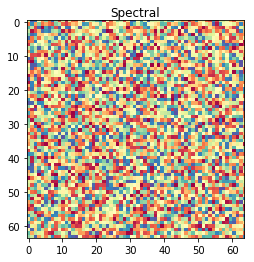

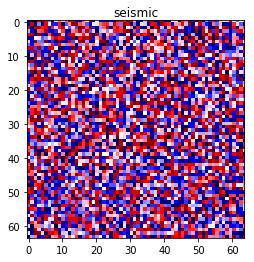

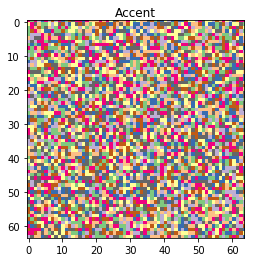

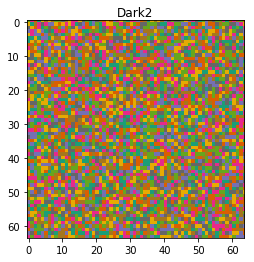

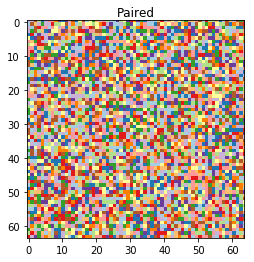

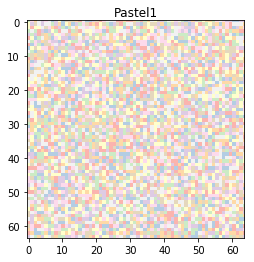

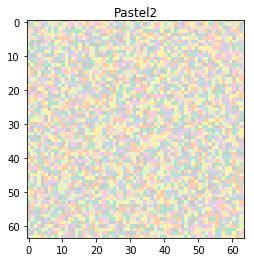

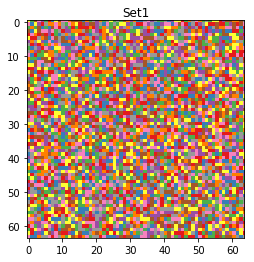

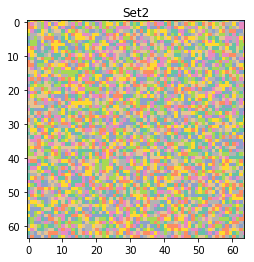

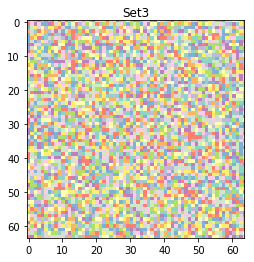

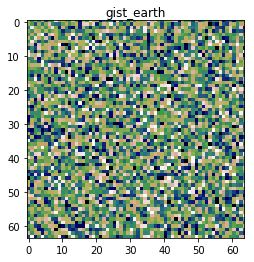

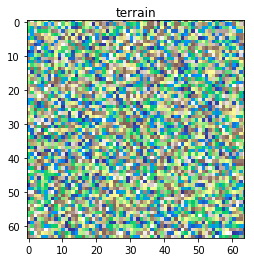

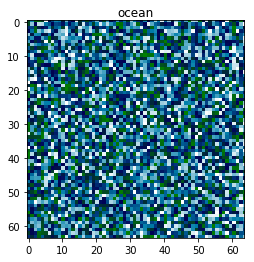

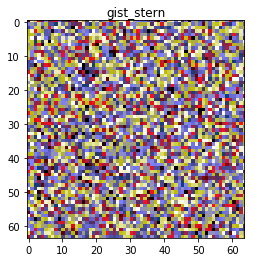

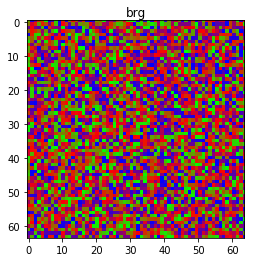

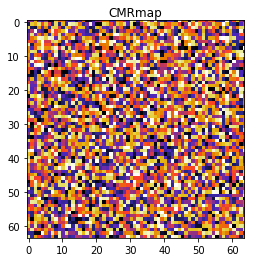

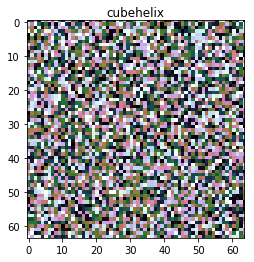

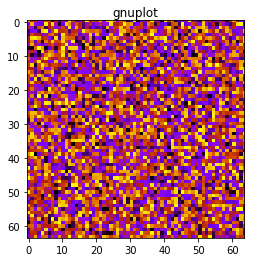

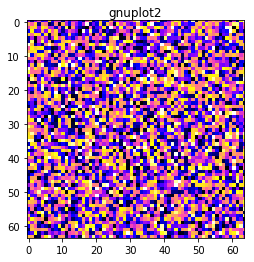

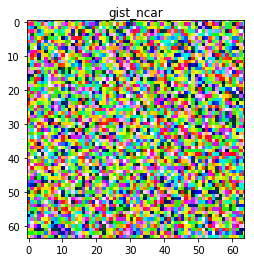

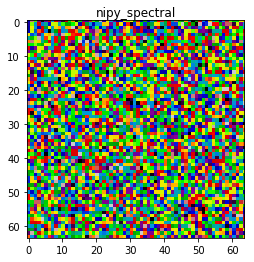

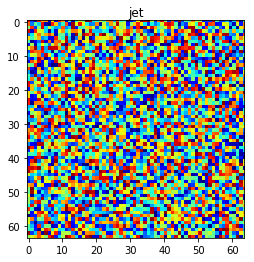

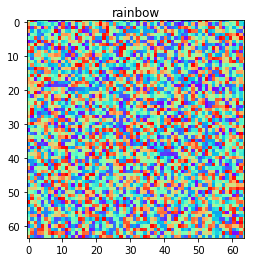

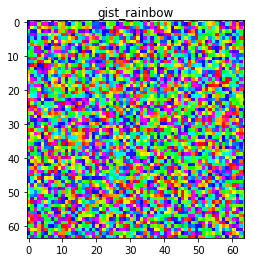

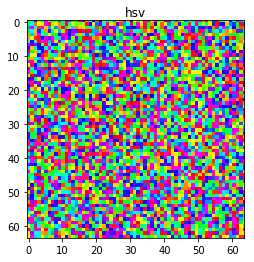

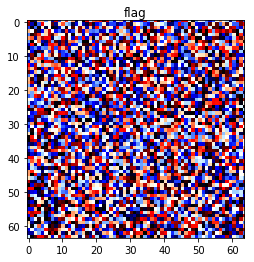

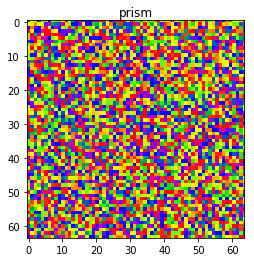

In [30]:
import matplotlib.colors

cmaps = ['viridis', 'inferno', 'plasma', 'magma', 
         'Blues', 'BuGn', 'BuPu',
         'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
         'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
         'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd',
         'afmhot', 'autumn', 'bone', 'cool',
         'copper', 'gist_heat', 'gray', 'hot',
         'pink', 'spring', 'summer', 'winter',
         'BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
         'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral', 'seismic',
         'Accent', 'Dark2', 'Paired', 'Pastel1',
         'Pastel2', 'Set1', 'Set2', 'Set3',
         'gist_earth', 'terrain', 'ocean', 'gist_stern',
         'brg', 'CMRmap', 'cubehelix',
         'gnuplot', 'gnuplot2', 'gist_ncar',
         'nipy_spectral', 'jet', 'rainbow',
         'gist_rainbow', 'hsv', 'flag', 'prism']

def random_color(img, name):
    cmap = matplotlib.colors.makeMappingArray(100, plt.get_cmap(name), gamma=1.0)
    for i in range(width):
        for j in range(height):
            intensity = np.random.random_sample(1)
            idx = (int) (intensity * 100)
            color = cmap[idx]
            img[i][j][0] = cmap[idx][0]
            img[i][j][1] = cmap[idx][1]
            img[i][j][2] = cmap[idx][2]
    return img

for name in cmaps:
    img = random_color(img, name)
    plt.figure()
    plt.imshow(img)
    plt.title(name)


## Test: Random stripes ##

* Each row (or column) has the same color value, randomly chosen from our colormap

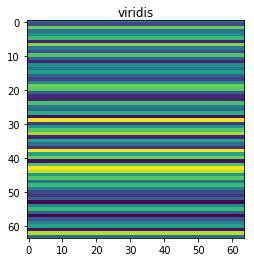

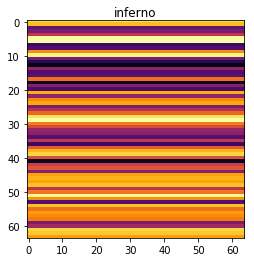

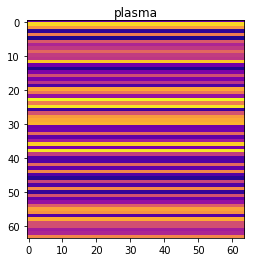

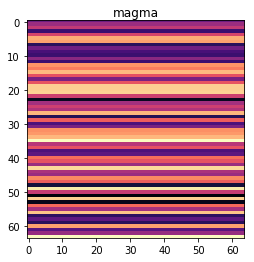

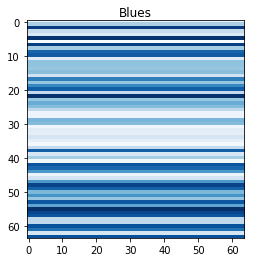

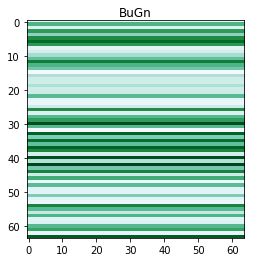

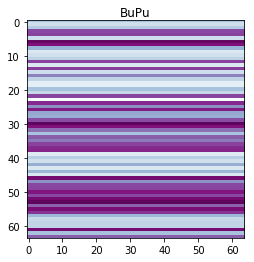

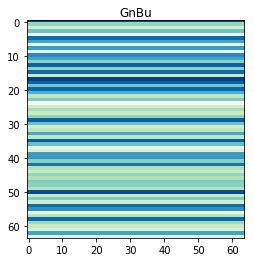

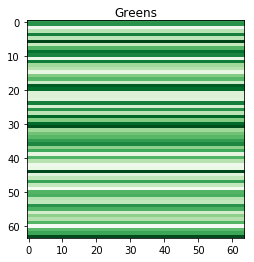

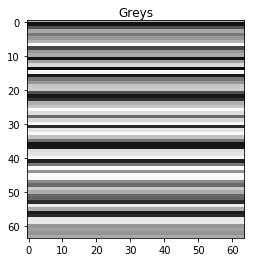

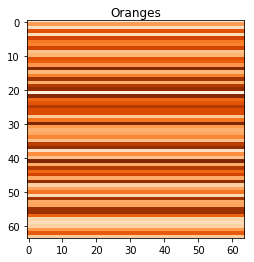

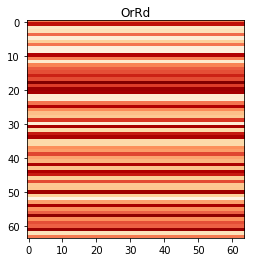

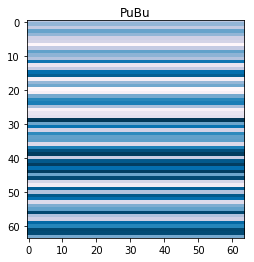

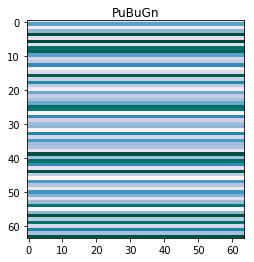

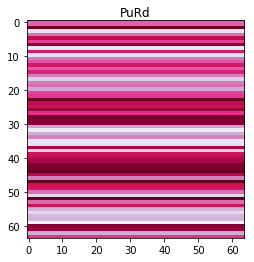

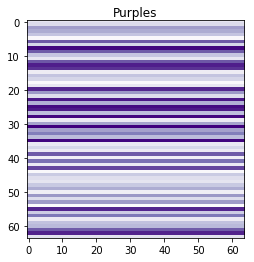

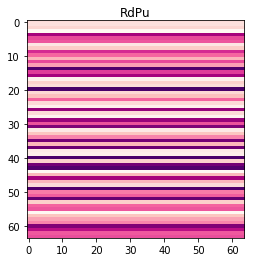

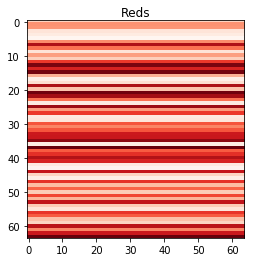

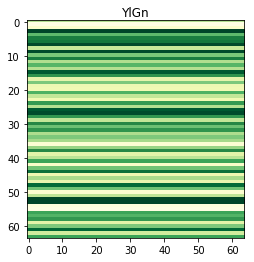

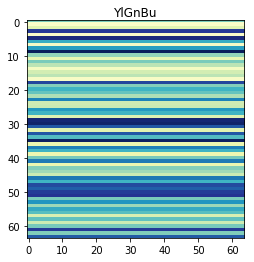

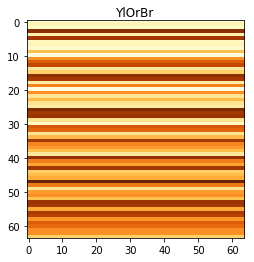

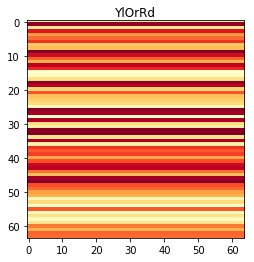

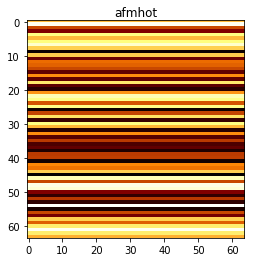

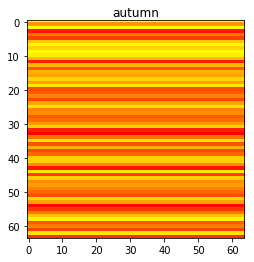

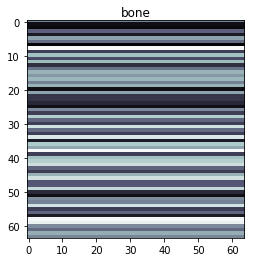

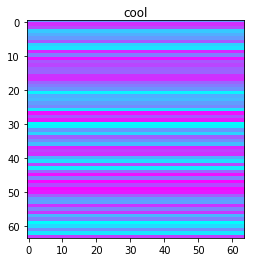

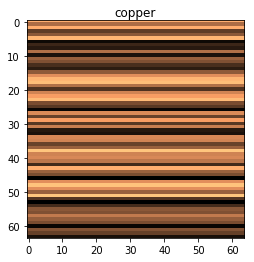

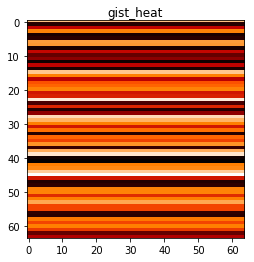

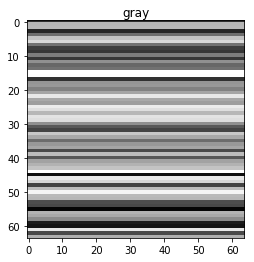

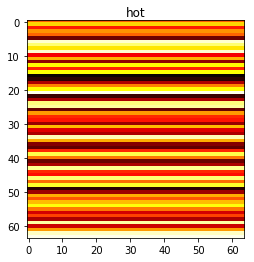

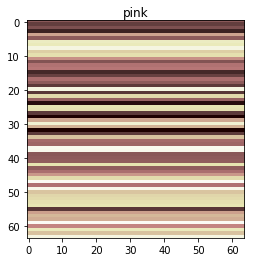

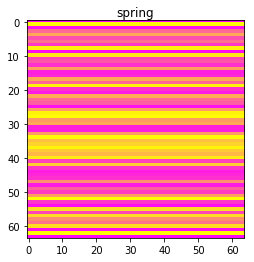

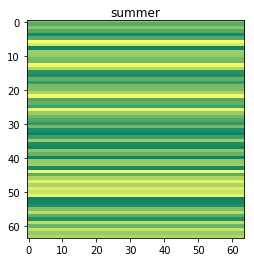

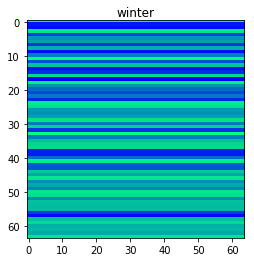

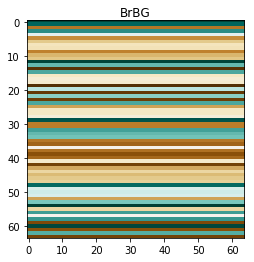

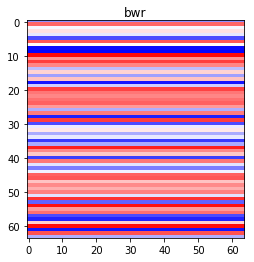

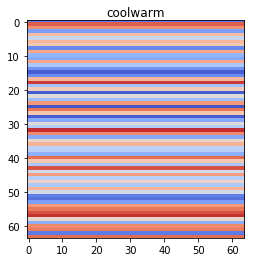

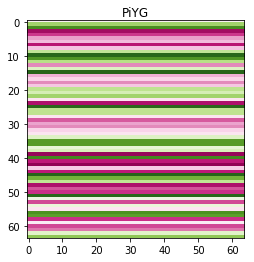

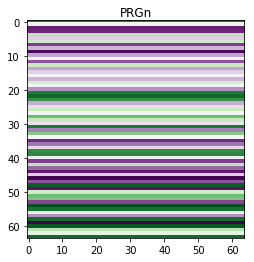

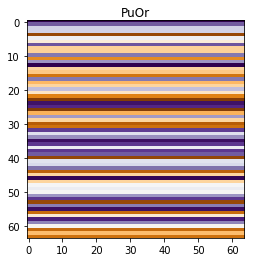

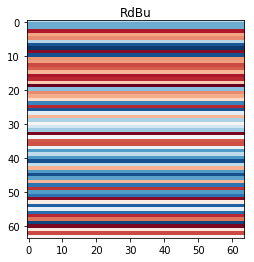

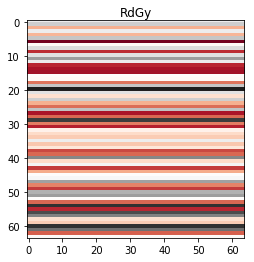

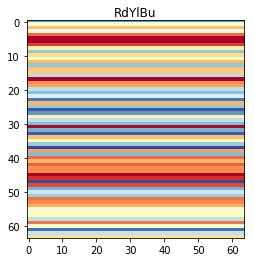

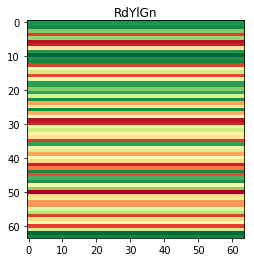

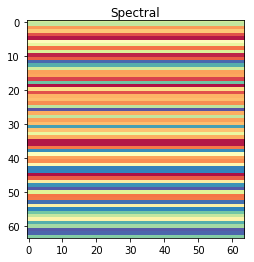

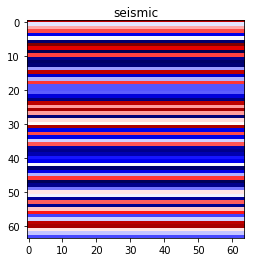

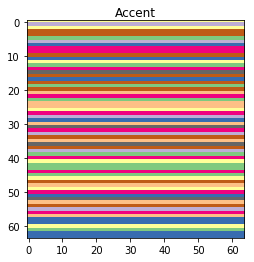

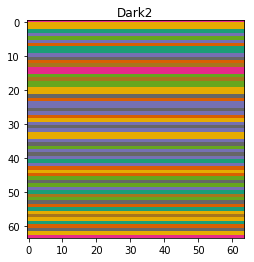

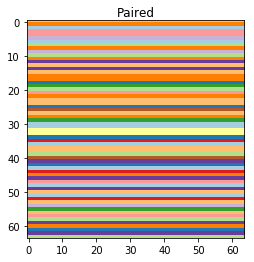

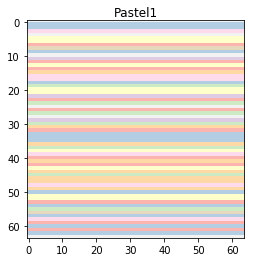

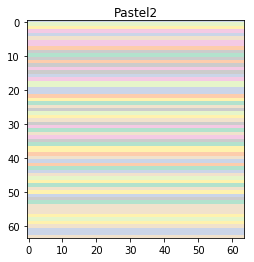

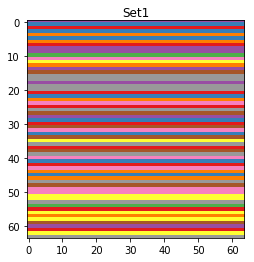

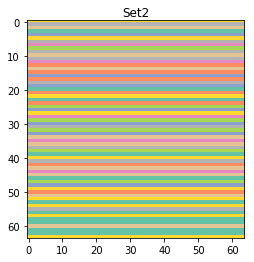

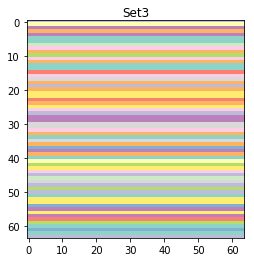

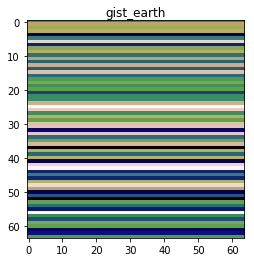

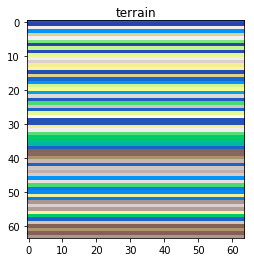

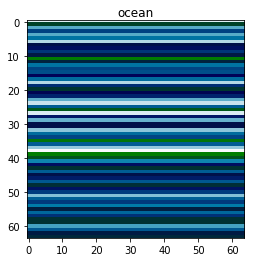

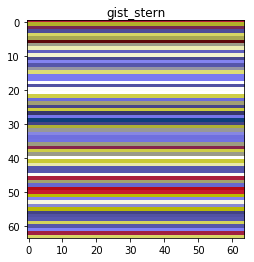

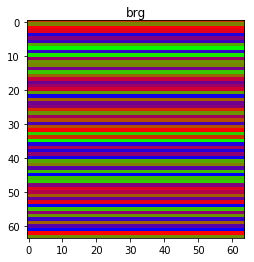

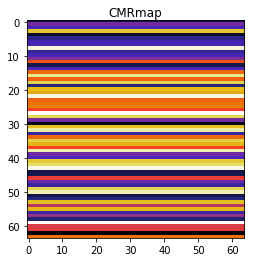

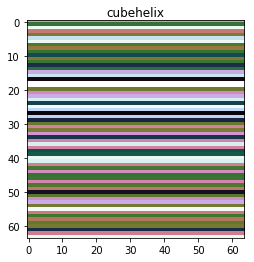

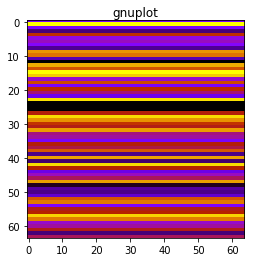

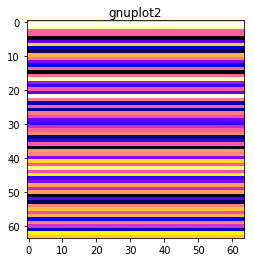

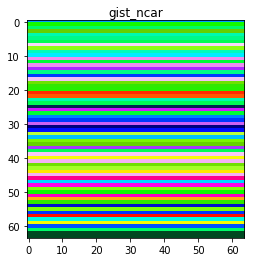

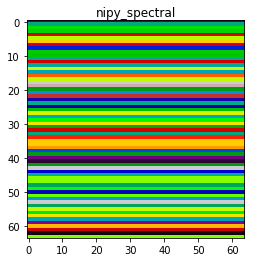

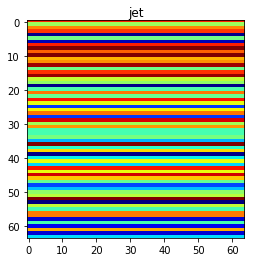

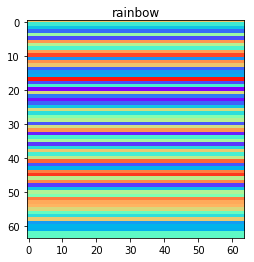

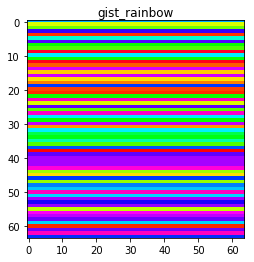

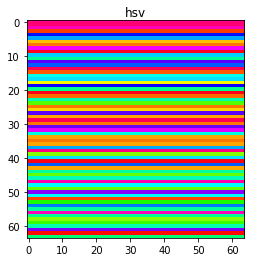

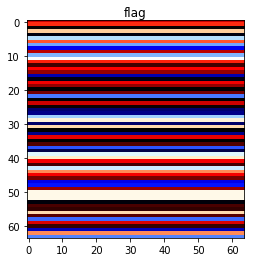

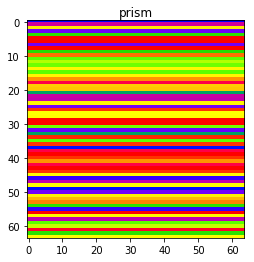

In [31]:
def random_stripes(img, name, stride):
    cmap = matplotlib.colors.makeMappingArray(100, plt.get_cmap(name), gamma=1.0)
    color = 0
    for i in range(height):      
        if i % stride == 0:
            intensity = np.random.random_sample(1)
            idx = (int) (intensity * 100)
            color = cmap[idx]
            
        for j in range(width):
            img[i][j][0] = cmap[idx][0]
            img[i][j][1] = cmap[idx][1]
            img[i][j][2] = cmap[idx][2]
        
    return img
    
for name in cmaps:
    img = random_stripes(img, name, 1)
    plt.figure()
    plt.imshow(img)
    plt.title(name)

## Test: Random gradients ##


* Gradients smoothly blend between two randomly chosen colors


* gradient_color = t * color1 + (1 - t) * color2, where t is in range  [0,1]

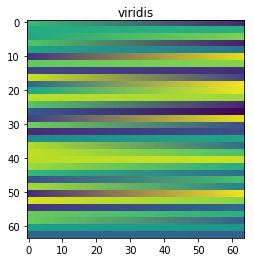

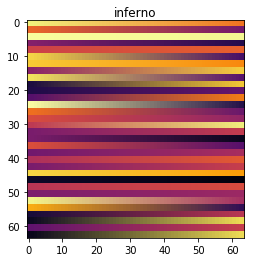

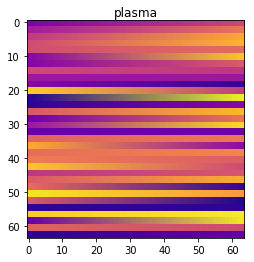

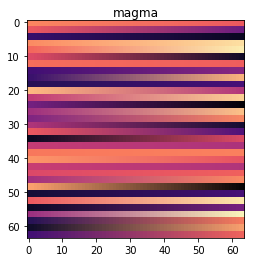

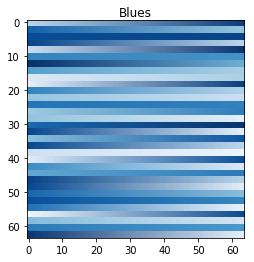

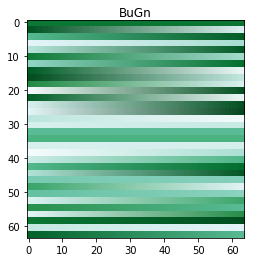

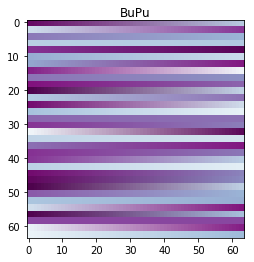

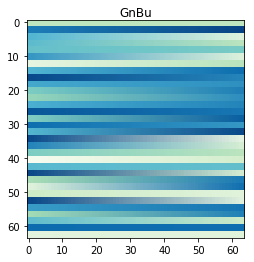

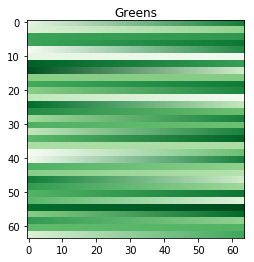

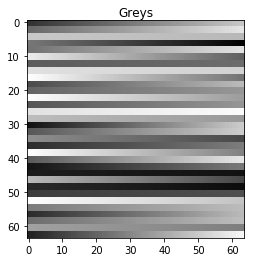

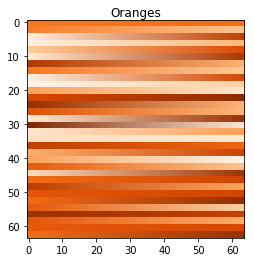

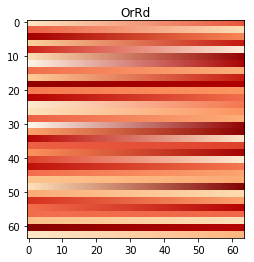

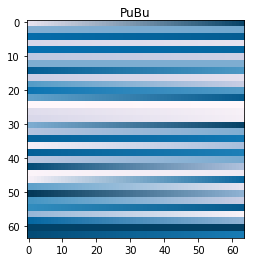

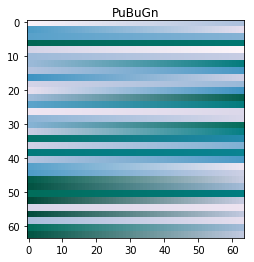

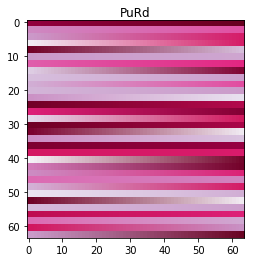

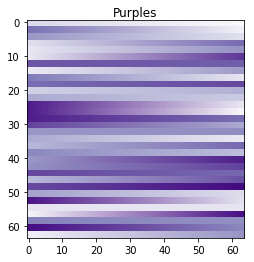

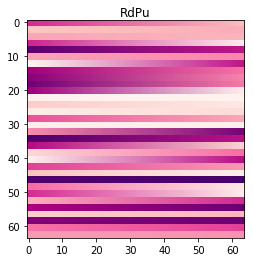

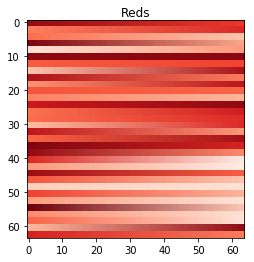

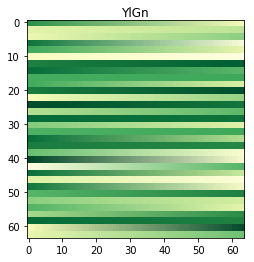

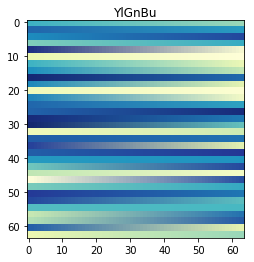

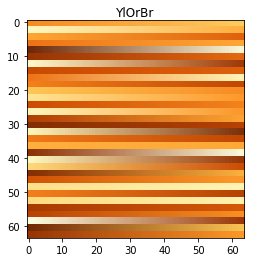

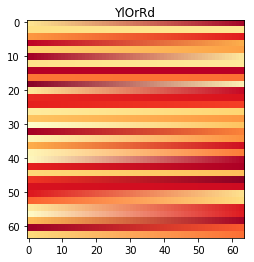

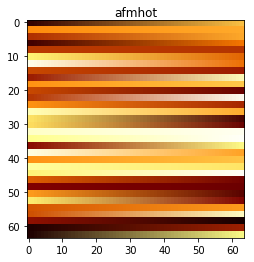

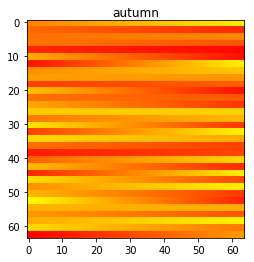

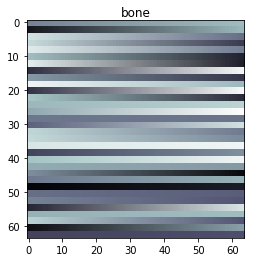

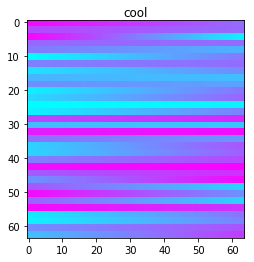

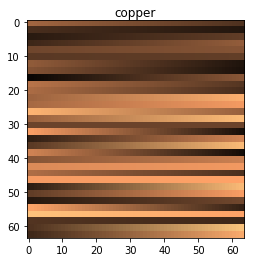

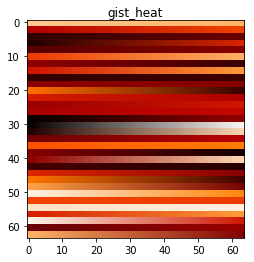

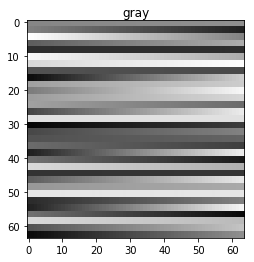

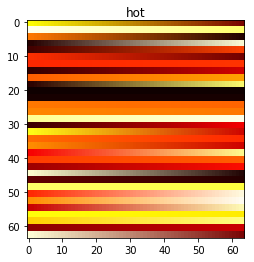

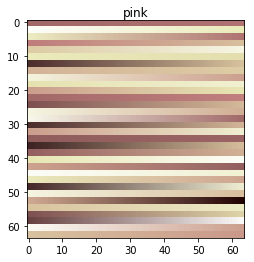

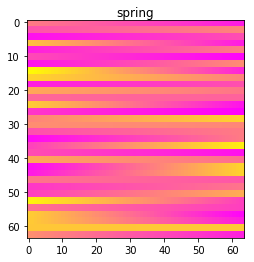

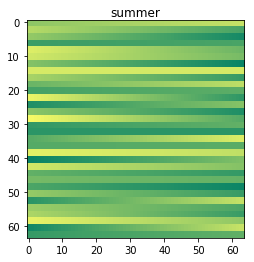

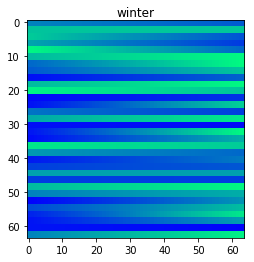

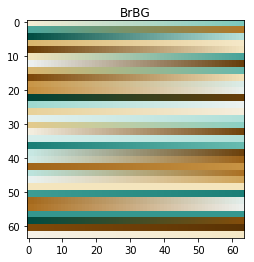

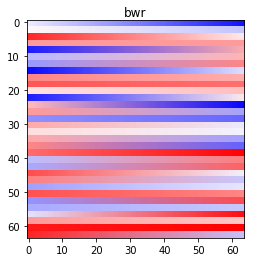

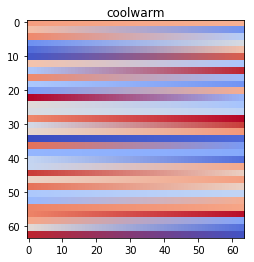

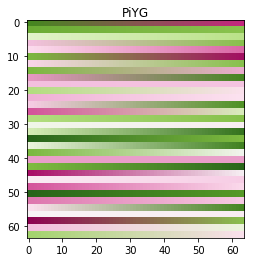

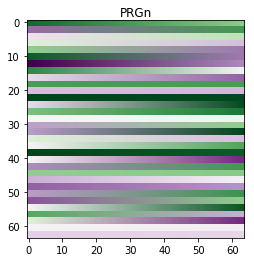

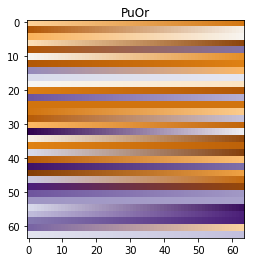

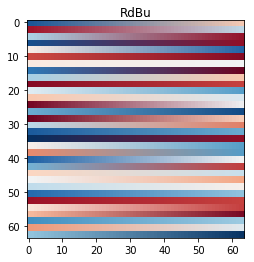

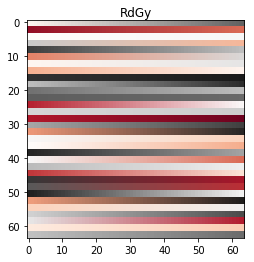

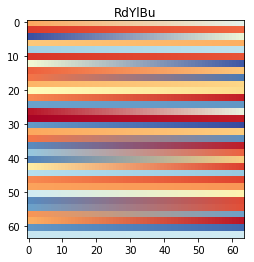

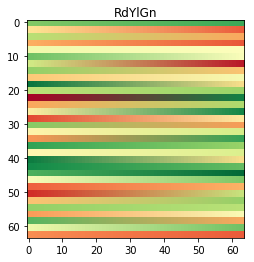

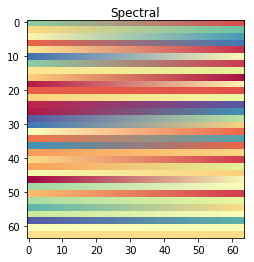

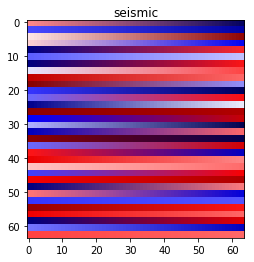

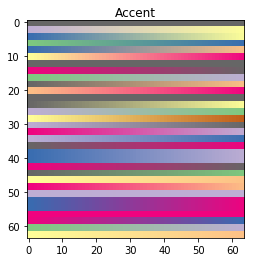

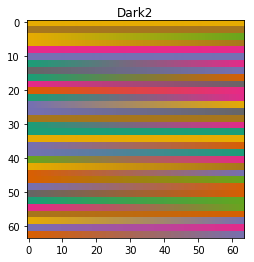

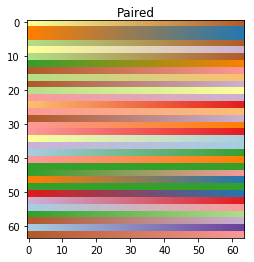

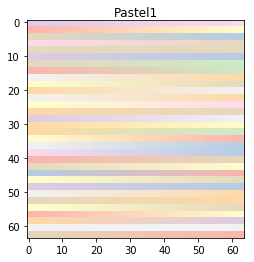

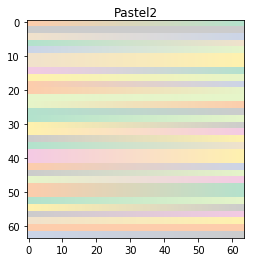

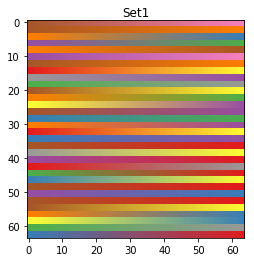

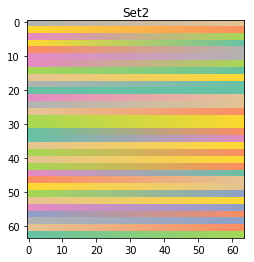

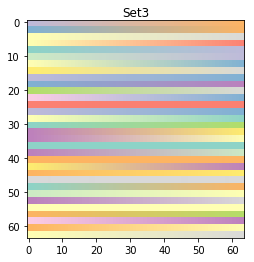

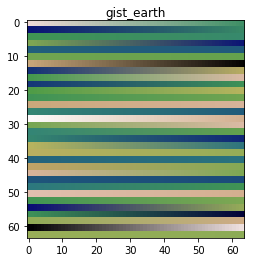

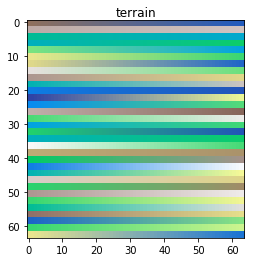

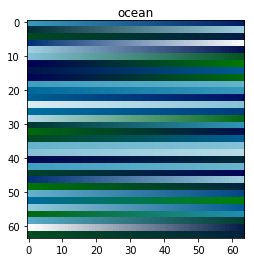

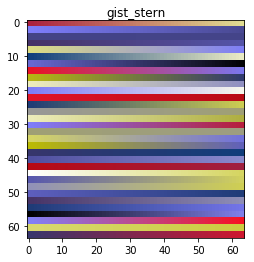

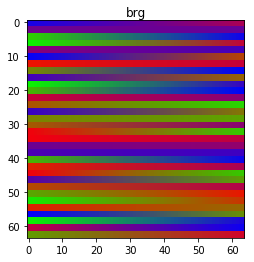

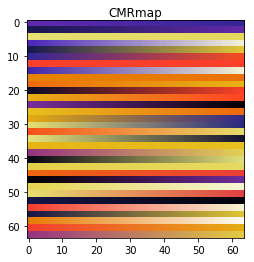

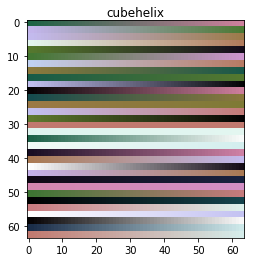

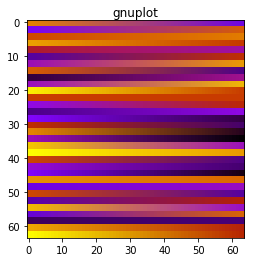

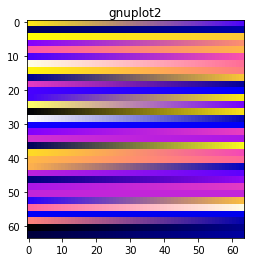

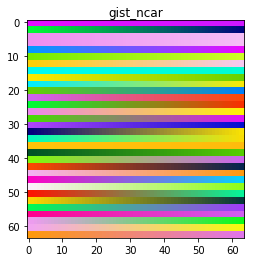

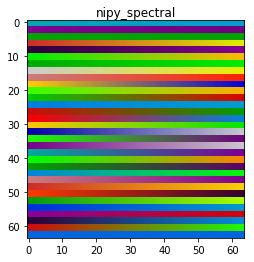

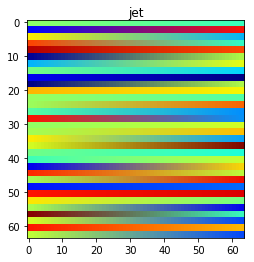

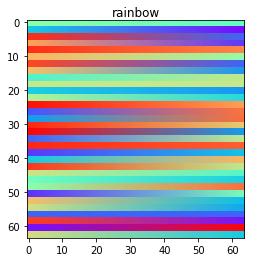

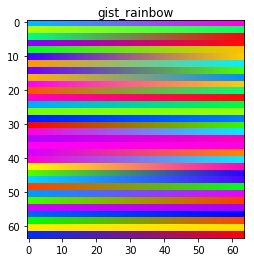

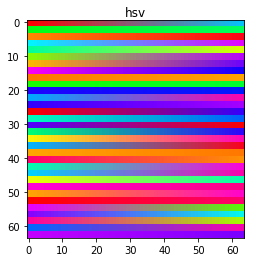

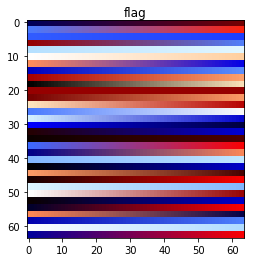

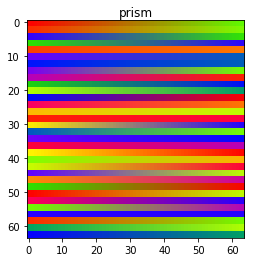

In [32]:
def random_gradients(img, name, stride):
    cmap = matplotlib.colors.makeMappingArray(100, plt.get_cmap(name), gamma=1.0)
    color1 = 0
    color2 = 0
    for i in range(height):      
        if i % stride == 0:
            intensity1, intensity2 = np.random.random_sample(2)
            
            idx1 = (int) (intensity1 * 100)
            color1 = cmap[idx1]

            idx2 = (int) (intensity2 * 100)
            color2 = cmap[idx2]
            
        for j in range(width):
            t = j/float(width)
            img[i][j][0] = t * cmap[idx1][0] + (1-t) * cmap[idx2][0]
            img[i][j][1] = t * cmap[idx1][1] + (1-t) * cmap[idx2][1]
            img[i][j][2] = t * cmap[idx1][2] + (1-t) * cmap[idx2][2]
        
    return img

for name in cmaps:
    img = random_gradients(img, name, 2)
    plt.figure()
    plt.imshow(img)
    plt.title(name)

## Test: Pixel pertubations (vertical) ##


* Each pixel color is chosen from a random vertical neighbor within range [-distance, distance]

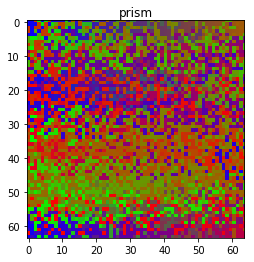

In [45]:
import random

def sub_vertical(img, distance):
    img2 = np.array(img)
    for i in range(height):                  
        for j in range(width):
            backpixel = min(height-1, max(0, i+random.randint(-distance,distance)))
            img2[i][j][0] = img[backpixel][j][0]
            img2[i][j][1] = img[backpixel][j][1]
            img2[i][j][2] = img[backpixel][j][2]
        
    return img2

img = random_gradients(img, "brg", 2)
img2 = sub_vertical(img, 5)
plt.figure()
plt.imshow(img2)
plt.title(name)

## Test: Pixel pertubations (horizontal) ##

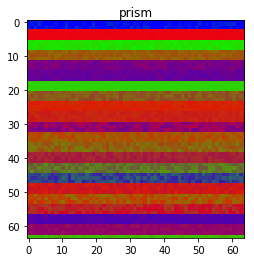

In [53]:
def sub_horizontal(img, distance):
    img2 = np.array(img)
    for i in range(height):                  
        for j in range(width):
            backpixel = min(height-1, max(0, i+random.randint(-distance,distance)))
            img2[i][j][0] = img[i][backpixel][0]
            img2[i][j][1] = img[i][backpixel][1]
            img2[i][j][2] = img[i][backpixel][2]
        
    return img2

img = random_gradients(img, "brg", 3)
img2 = sub_horizontal(img, 10)
plt.figure()
plt.imshow(img2)
plt.title(name)

## Test: Box blur smoothing ##

* Smoothing replaces each pixel with an average of its neighbors


* Below we use a box filter to smooth, each pixel is weighted evenly
```
pixel = 1/numPixels * (sum(neighbor_pixels))
```

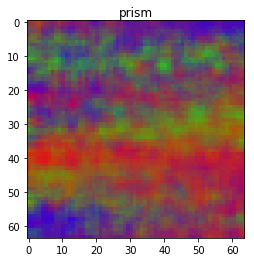

In [61]:
def smoothBox(img, neighborhood): # box blur
    img2 = np.array(img)
    for i in range(height):                  
        for j in range(width):
            aveR = img[i][j][0]
            aveG = img[i][j][1]
            aveB = img[i][j][2]
            count = 0.0
            for ii in range(i-neighborhood, i+neighborhood):
                ki = min(height-1, max(0, ii))
                for jj in range(j-neighborhood, j+neighborhood):
                    kj = min(width-1, max(0, jj))
                    aveR += img[ki][kj][0]
                    aveG += img[ki][kj][1]
                    aveB += img[ki][kj][2]
                    count += 1.0
                    
            img2[i][j][0] = aveR/count
            img2[i][j][1] = aveG/count
            img2[i][j][2] = aveB/count
    return img2

img = random_gradients(img, "brg", 2)
img2 = sub_vertical(img, 5)
img3 = smoothBox(img2, 2)
plt.figure()
plt.imshow(img3)
plt.title(name)

## Test: Smearing ##

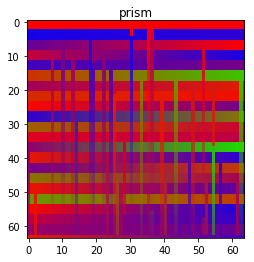

In [123]:
def pixel_smear_horizontal(img, numPixels, aveLength): 
    img2 = np.array(img)
    
    pixelis = np.random.random_integers(0,63,numPixels)
    pixeljs = np.random.random_integers(0,63,numPixels)    
    for i,j in zip(pixelis, pixeljs):        
        distance = aveLength #random.randint(-aveLength,aveLength)
        endj = min(width-1, max(0, j + distance))
        color = img[pixelis[0]][pixeljs[0]]
        for jj in range(j, endj):
            t = float(jj - j)/distance         
            img2[i][jj][0] = (1-t) * img[i][jj][0] + t * color[0]
            img2[i][jj][1] = (1-t) * img[i][jj][1] + t * color[1]
            img2[i][jj][2] = (1-t) * img[i][jj][2] + t * color[2]
    return img2

def pixel_smear_vertical(img, numPixels, aveLength): 
    img2 = np.array(img)
    
    pixelis = np.random.random_integers(0,63,numPixels)
    pixeljs = np.random.random_integers(0,63,numPixels)

    for i,j in zip(pixelis, pixeljs):        
        distance = aveLength #random.randint(-aveLength,aveLength)
        endi = min(height-1, max(0, i + distance))
        color = img[i][j]
        for ii in range(i, endi):
            t = float(ii - i)/distance         
            img2[ii][j][0] = t * img[ii][j][0] + (1-t) * color[0]
            img2[ii][j][1] = t * img[ii][j][1] + (1-t) * color[1]
            img2[ii][j][2] = t * img[ii][j][2] + (1-t) * color[2]
    return img2

img = random_gradients(img, "brg", 3)
img2 = pixel_smear_vertical(img, 50, 50)
plt.figure()
plt.imshow(img2)
plt.title(name)


## Test: Perturb pixels by moving blocks ##

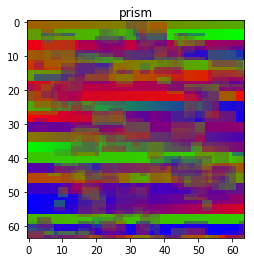

In [102]:

def copy_block(img, size, blend): 
    img2 = np.array(img)

    # block to copy
    iSource,jSource = np.random.random_integers(0,64,2)
    iTarget,jTarget = np.random.random_integers(0,64,2)
    #print iSource,jSource,iTarget,jTarget,size
    
    for i in range(size):
        for j in range(size):
            iiTarget = min(width-1, iTarget+i)
            jjTarget = min(height-1, jTarget+j)

            iiSource = min(width-1, iSource+i)
            jjSource = min(height-1, jSource+j)
            
            img2[iiTarget][jjTarget][0] = (1-blend) * img[iiTarget][jjTarget][0] + blend * img[iiSource][jjSource][0]
            img2[iiTarget][jjTarget][1] = (1-blend) * img[iiTarget][jjTarget][1] + blend * img[iiSource][jjSource][1]
            img2[iiTarget][jjTarget][2] = (1-blend) * img[iiTarget][jjTarget][2] + blend * img[iiSource][jjSource][2]
    return img2

img = random_gradients(img, "brg", 3)
for i in range(100):    
    img = copy_block(img, random.randint(2,10), 0.4)
    
plt.figure()
plt.imshow(img)
plt.title(name)


## Test: Color jitter ##

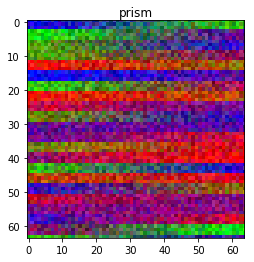

In [116]:
def jitter(img, jitter):  
    img2 = np.array(img)

    for i in range(width):
        for j in range(height):
            r = (random.random() - 0.5) * 2.0 * jitter[0]
            g = (random.random() - 0.5) * 2.0 * jitter[1]
            b = (random.random() - 0.5) * 2.0 * jitter[2]

            img2[i][j][0] = min(1, max(0, img[i][j][0] + r))
            img2[i][j][1] = min(1, max(0, img[i][j][1] + g))
            img2[i][j][2] = min(1, max(0, img[i][j][2] + b))
    return img2

img = random_gradients(img, "brg", 3)
img = jitter(img, [0.2,0.2,0.2])
    
plt.figure()
plt.imshow(img)
plt.title(name)


## Animating generated images ##

* Blend between subsequent generated images


* Blending is computed by combining the pixels of two images, t in [0,1]
```
image_blend = t * image1 + (1 - t) * image 2
```



<tr>
    <td> <img src="./examples/canvas2.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="./examples/canvas3.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="./examples/canvas4.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="./examples/canvas5.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> = </td>
    <td> <img src="./examples/StaticEffect.gif" alt="Drawing" style="width: 250px;"/> </td>
</tr>
<tr>
    <td> 1 </td>
    <td> 2</td>
    <td> 3 </td>
    <td> 4 </td>
    <td> </td>
    <td> Animated </td>
</tr>


Ideas
- Use sinwaves (perhaps modulated with noise) to generate random points for smearing
- Use different distributions (gaussian, poisson) for random points to give structure to changes in colors
- Implement swapblock
- Try layering noise textures with blending
- Generate patterns by sprinkling points of different colors and then using barycentric blending between them
- glow effects
- have different regions be colored by different color maps

Additional resources
1. http://lodev.org/cgtutor/randomnoise.html
2. https://en.wikipedia.org/wiki/Perlin_noise
3. http://flafla2.github.io/2014/08/09/perlinnoise.html